In [1]:
import anatomist.api as ana
from soma.qt_gui.qtThread import QtThreadCall
from soma.qt_gui.qt_backend import Qt

from soma import aims
import numpy as np
import pandas as pd
import os
import glob

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
a = ana.Anatomist()

create qapp
global modules: /casa/host/build/share/anatomist-5.2/python_plugins
home   modules: /casa/home/.anatomist/python_plugins
loading module meshsplit
done
Starting Anatomist.....
config file : /casa/home/.anatomist/config/settings.cfg
PyAnatomist Module present
PythonLauncher::runModules()
loading module palettecontrols


existing QApplication: 0
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-jc225751'


loading module volumepalettes
loading module save_resampled
loading module profilewindow
loading module statsplotwindow
loading module anacontrolmenu
loading module infowindow
loading module foldsplit
loading module simple_controls
loading module histogram
loading module valuesplotwindow
loading module ana_image_math
loading module modelGraphs
loading module paletteViewer
loading module bsa_proba
loading module gradientpalette
loading module selection
loading module gltf_io
all python modules loaded
Anatomist started.


### Variable definitions

In [3]:
path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_left"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
lab = "BrainVolumeFreeSurfer_mm3"
model_path = glob.glob(f"{path}/*")[0]
embeddings_file = f"{model_path}/ukb40_random_epoch80_embeddings/full_embeddings.csv"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"

In [4]:
side = "L" # "R" or "L"
region = "F.Coll.-S.Rh." # "S.C.-sylv.", "ORBITAL", "CINGULATE", "SC-sylv", "F.I.P."
database='ukb'

# Building predictors

In [5]:
participants = pd.read_csv(participants_file, index_col=0)
participants = participants[[lab]].dropna()
participants

,BrainVolumeFreeSurfer_mm3
participant_id,
sub-3411469,1136465.0
sub-2290292,1079118.0
sub-3842391,1124077.0
sub-2758537,1246758.0
sub-4334619,1410387.0
...,...
sub-2621329,1260788.0
sub-5057890,1328760.0
sub-2038574,1244624.0


In [6]:
ukb_emb = pd.read_csv(f"{embeddings_file}", index_col=0)
merged = participants[[lab]].merge(ukb_emb, left_index=True, right_index=True)


In [7]:
embeddings = merged.iloc[:,1:]
label = merged.iloc[:,0:1]
label_random = label.copy()
label_random[:] = label_random.sample(frac=1).values
# print(embeddings.head())
print(label.head())
print(label_random.head())

# Construct nearest_neighbor matrix
nbrs = NearestNeighbors(n_neighbors=2000, algorithm='brute').fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)
indices.shape

             BrainVolumeFreeSurfer_mm3
sub-3411469                  1136465.0
sub-2290292                  1079118.0
sub-3842391                  1124077.0
sub-2758537                  1246758.0
sub-4334619                  1410387.0
             BrainVolumeFreeSurfer_mm3
sub-3411469                  1145550.0
sub-2290292                  1101749.0
sub-3842391                  1140343.0
sub-2758537                  1203873.0
sub-4334619                   984036.0


(37715, 2000)

In [8]:
label

,BrainVolumeFreeSurfer_mm3
sub-3411469,1136465.0
sub-2290292,1079118.0
sub-3842391,1124077.0
sub-2758537,1246758.0
sub-4334619,1410387.0
...,...
sub-2621329,1260788.0
sub-5057890,1328760.0
sub-2038574,1244624.0
sub-1415693,1044867.0


array([[<AxesSubplot:title={'center':'BrainVolumeFreeSurfer_mm3'}>]],
      dtype=object)

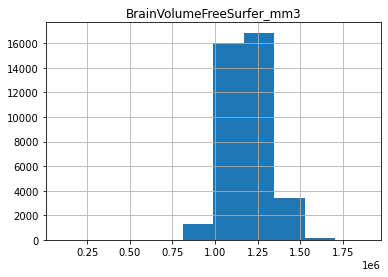

In [9]:
%matplotlib inline
label.hist()

In [10]:
def construct_average_nearest_neighbors_continuous(label, indices=indices):
    label_red = label.reset_index().iloc[:,[1]].values

    # In the indices matrix, put value of label corresponding to index
    neighbors = indices[:,1:]
    labels1 = np.zeros(neighbors.shape)
    for idx in range(len(neighbors)):
        for j in range(neighbors.shape[1]):
            labels1[idx, j] = label_red[neighbors[idx, j]]
    
    # Makes moving average along nearest neighbor
    labels1_cum = np.cumsum(labels1, axis=1)
    
    means_npy = np.zeros(labels1_cum.shape)
    for idx in range(len(labels1)):
        means_npy[idx,:] = labels1_cum[idx,:]/(np.arange(1, labels1_cum.shape[1]+1, 1).reshape(1,-1))
        
    return labels1, means_npy

In [11]:
values_npy, means_npy = construct_average_nearest_neighbors_continuous(label)

/tmp/ipykernel_117173/1831665505.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels1[idx, j] = label_red[neighbors[idx, j]]


In [12]:
nb_neighbors=1000
label.iloc[indices[np.argmin(means_npy[:, nb_neighbors]),:nb_neighbors],:]

,BrainVolumeFreeSurfer_mm3
sub-1623075,1113372.0
sub-4830572,1041715.0
sub-2860056,1074766.0
sub-1921263,1007023.0
sub-2470801,1136875.0
...,...
sub-3962687,1147460.0
sub-1147000,1143045.0
sub-1062462,1189705.0
sub-2821892,1048166.0


In [13]:
nb_neighbors=1000
label.iloc[indices[np.argmax(means_npy[:, nb_neighbors]),:nb_neighbors],:]

,BrainVolumeFreeSurfer_mm3
sub-3327587,1291197.0
sub-2565037,1369042.0
sub-4090427,1207453.0
sub-3789386,1428808.0
sub-4787289,1447525.0
...,...
sub-3737669,1020549.0
sub-1377679,1226802.0
sub-4106358,1082109.0
sub-4733683,1376324.0


### Function definitions

In [14]:
def to_bucket(obj):
    if obj.type() == obj.BUCKET:
        return obj
    avol = a.toAimsObject(obj)
    c = aims.Converter(intype=avol, outtype=aims.BucketMap_VOID)
    abck = c(avol)
    bck = a.toAObject(abck)
    bck.releaseAppRef()
    return bck

def build_gradient(pal):
    gw = ana.cpp.GradientWidget(None, 'gradientwidget', pal.header()['palette_gradients'])
    gw.setHasAlpha(True)
    nc = pal.shape[0]
    rgbp = gw.fillGradient(nc, True)
    rgb = rgbp.data()
    npal = pal.np['v']
    pb = np.frombuffer(rgb, dtype=np.uint8).reshape((nc, 4))
    npal[:, 0, 0, 0, :] = pb
    npal[:, 0, 0, 0, :3] = npal[:, 0, 0, 0, :3][:, ::-1]  # BGRA -> RGBA
    pal.update()

def buckets_average(subject_id_list, dataset_name_list):
    dic_vol = {}
    dim = 0
    rep = 0
    if len(subject_id_list) == 0:
        return False
    while dim == 0 and rep < len(subject_id_list):
        if dataset_name_list[rep].lower() in ['ukb', 'ukbiobank', 'projected_ukb']:
            dataset = 'UkBioBank40'
        elif dataset_name_list[rep].lower() in ['hcp']:
            dataset = 'hcp'
        mm_skeleton_path = f"/neurospin/dico/data/deep_folding/current/datasets/{dataset}/crops/2mm/{region}/mask/{side}crops"
        if os.path.isfile(f'{mm_skeleton_path}/{subject_id_list[rep]}_cropped_skeleton.nii.gz'):
            sum_vol = aims.read(f'{mm_skeleton_path}/{subject_id_list[rep]}_cropped_skeleton.nii.gz').astype(float)
            dim = sum_vol.shape
            sum_vol.fill(0)
        else: 
            print(f'FileNotFound {mm_skeleton_path}/{subject_id_list[rep]}_cropped_skeleton.nii.gz')
            #raise FileNotFoundError(f'{mm_skeleton_path}/{subject_id_list[0]}_cropped_skeleton.nii.gz')
        rep += 1

    for subject_id, dataset in zip(subject_id_list,dataset_name_list):
        if dataset.lower() in ['ukb', 'ukbiobank',  'projected_ukb']:
            dataset = 'UkBioBank40'
        elif dataset.lower() == 'hcp':
            dataset = 'hcp'
            
        mm_skeleton_path = f"/neurospin/dico/data/deep_folding/current/datasets/{dataset}/crops/2mm/{region}/mask/{side}crops"

        if os.path.isfile(f'{mm_skeleton_path}/{subject_id}_cropped_skeleton.nii.gz'):
            vol = aims.read(f'{mm_skeleton_path}/{subject_id}_cropped_skeleton.nii.gz')
            # compare the dim with the first file dim

            if vol.np.shape != dim:
                raise ValueError(f"{subject_id_list[0]} and {subject_id} must have the same dim")

                
            # to have a binary 3D structure
            dic_vol[subject_id] = (vol.np > 0).astype(int)
            sum_vol.np[:] += (vol.np > 0).astype(int) 
        else: 
            print(f'FileNotFound {mm_skeleton_path}/{subject_id}_cropped_skeleton.nii.gz')
            #raise FileNotFoundError(f'{mm_skeleton_path}/{subject_id}_cropped_skeleton.nii.gz')

    sum_vol = sum_vol / len(subject_id_list)
    print(sum_vol, sum_vol.shape)
    return sum_vol

In [15]:
def visualize_averages_along_parameter(df, column_name, database, nb_subjects_per_average=200, nb_columns=5, nb_lines=3):
    # anatomist objects
    global _block
    global _average_dic
    global dic_packages
    nb_windows = nb_columns * nb_lines
    _average_dic = {}
    step = nb_subjects_per_average # number of subjects on which average is done
    # Creates the block if it has not been created
    # try:
    #     _block
    # except NameError:
    _block = a.createWindowsBlock(nb_columns)

    # Order according to column_name
    # df = df.sort_values(column_name)
    # predict_proba = df[[column_name]]
    predict_proba = df

    # Creates dictionary of subjects to average
    dic_packages = {}
    for i in range(0,len(predict_proba),step):
        list_idx = (predict_proba.index[i:i+step].to_numpy())
        dic_packages[i//step] = list_idx
    
    # Ensures that last list contains the last step subjects
    list_idx = (predict_proba.index[-step:].to_numpy())
    dic_packages[i//step] = list_idx
    
    list_database = [database for i in range(step)]
    n_pack = len(dic_packages)

    # Loop of display averages
    list_pack = [int(np.ceil(i*n_pack/float(nb_windows))) for i in range(0,nb_windows)]
    for i in list_pack:
        sum_vol = buckets_average(dic_packages[i], list_database)
        _average_dic[f'a_sum_vol{i}'] = a.toAObject(sum_vol)
        _average_dic[f'a_sum_vol{i}'].setPalette(minVal=0, absoluteMode=True)
        #wsum = a.createWindow('Sagittal', block=block)
        #wsum.addObjects(a_sum_vol)
        _average_dic[f'rvol{i}'] = a.fusionObjects(
            objects=[_average_dic[f'a_sum_vol{i}']],
            method='VolumeRenderingFusionMethod')
        _average_dic[f'rvol{i}'].releaseAppRef()
        # custom palette
        n = len(dic_packages[i])
        pal = a.createPalette('VR-palette')
        pal.header()['palette_gradients'] = '0;0.459574;0.497872;0.910638;1;1#0;0;0.52766;0.417021;1;1#0;0.7;1;0#0;0;0.0297872;0.00851064;0.72766;0.178723;0.957447;0.808511;1;1'
        #f'0;0.244444;0.5;1;1;1#0;0;0.535897;0.222222;1;1#0;0.7;1;0#0;0;{0.5/n};0;1;1'
        build_gradient(pal)
        _average_dic[f'rvol{i}'].setPalette('VR-palette', minVal=0.05, absoluteMode=True)
        pal2 = a.createPalette('slice-palette')
        pal2.header()['palette_gradients'] = '0;0.459574;0.497872;0.910638;1;1#0;0;0.52766;0.417021;1;1#0;0.7;1;0#0;0;0.0297872;0.00851064;0.72766;0.178723;0.957447;0.808511;1;1'
        #f'0;0.244444;0.5;1;1;1#0;0;0.535897;0.222222;1;1#0;0.7;1;0#0;0;{0.3/n};0;{0.7/n};1;1;1'
        build_gradient(pal2)
        _average_dic[f'a_sum_vol{i}'].setPalette('slice-palette')
        # rvol.palette().fill()
        _average_dic[f'wvr{i}'] = a.createWindow('3D', block=_block)
        _average_dic[f'wvr{i}'].addObjects(_average_dic[f'rvol{i}'])

### Visualization

In [22]:
%matplotlib qt5
# block = a.createWindowsBlock(10)
# visualize_averages_along_parameter(df, "predicted", database, nb_subjects_per_average=1)
nb_neighbors=1000
df = label.iloc[indices[np.argmin(means_npy[:, nb_neighbors]),:nb_neighbors],:]
visualize_averages_along_parameter(df, "predicted", database, nb_subjects_per_average=200, nb_columns=3, nb_lines=1)

<soma.aims.Volume_DOUBLE object at 0x75cab8bd83a0> (29, 62, 36, 1)
<soma.aims.Volume_DOUBLE object at 0x75cac9faa950> (29, 62, 36, 1)
<soma.aims.Volume_DOUBLE object at 0x75cab014a830> (29, 62, 36, 1)


no position could be read at 391, 587
no position could be read at 185, 455


# Displaying subjects

In [17]:
# list_subjects = list_smallest
# block = a.createWindowsBlock(5) # 5 columns
# dic_windows = {}
# for subject in list_subjects:
#     path_to_t1mri = f'/neurospin/dico/data/bv_databases/human/not_labeled/hcp/hcp/{subject}/t1mri/BL'
#     dic_windows[f'w{subject}'] = a.createWindow("3D", block=block)
#     dic_windows[f'white_{subject}'] = a.loadObject(f'{path_to_t1mri}/default_analysis/segmentation/mesh/{subject}_{side}white.gii')
#     dic_windows[f'white_{subject}'].loadReferentialFromHeader()
#     dic_windows[f'sulci_{subject}'] = a.loadObject(f'{path_to_t1mri}/default_analysis/folds/3.1/{side}{subject}.arg')
#     dic_windows[f'sulci_{subject}'].loadReferentialFromHeader()
#     dic_windows[f'w{subject}'].addObjects([dic_windows[f'white_{subject}'], dic_windows[f'sulci_{subject}']])

In [18]:
# df.sort_values("predicted")[::10]

In [19]:
# df_concat = pd.concat([df.sort_values("predicted")[::10][:5], df.sort_values("predicted")[::10][-5:]])

In [20]:
# df_concat

In [21]:
# visualize_averages_along_parameter(df_concat, "predicted", database, nb_subjects_per_average=1, nb_columns=5, nb_lines=2)

QLayout: Attempting to add QLayout "" to QWidget "", which already has a layout


no position could be read at 318, 407
no position could be read at 237, 592
